In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl
from gwpy.timeseries import TimeSeries
import math
import random

In [2]:
epochs = 200
test_sample_ratio = .2
validation_sample_ratio = 0.1
input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 1400

In [227]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
def normalize(v):
    norm = np.linalg.norm(v)
    junk = 0
    if norm == 0: 
       return v, junk, norm
    return v / norm, junk, norm

In [5]:
def bunch_normalization(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    v_set_normalized = np.zeros((v_set.shape[0], v_set.shape[1]))
    for i in range(len(v_set)):
        v_set_normalized[i], recover_min[i], recover_coef[i] = normalize(v_set[i])
    return v_set_normalized, recover_min, recover_coef

In [6]:
def TPR_calculation(noise_distribution, signal_distribution, FPR):
    threshold_rank = len(noise_distribution) * FPR
    threshold = np.partition(noise_distribution, -threshold_rank)[-threshold_rank]
    
    TPR = np.argwhere(signal_distribution > threshold).shape[0] / len(signal_distribution)
    
    return TPR

Import Data here
----

In [299]:
np.savez('../Data_cached/nonuninorm_dataset_cached.npz', train = X_train, test = X_test, BBH = data_injected_normalized, SG = data_sinegaussian_normalized, simulated_glitches = data_glitches_fake_normalized, real_glitches = data_glitches_real_normalized)

In [228]:
data_for_training_and_testing = np.load("../Data_cached/4000Hz25msnoisesample.npy") * 1e21

In [229]:
data_for_training_and_testing = np.load("../Data_cached/4000Hz25msnoisesample1e6.npy") * 1e21

In [230]:
data_injected = np.delete(np.load("../Data_cached/4000Hz25msdatasampleBBH.npy") * 1e21, 47, axis = 0)

In [231]:
data_injected = np.load("../Data_cached/4000Hz25msdatasampleBBH3346.npy") * 1e21

In [232]:
np.linalg.norm(data_injected, axis = 1).mean()

1.958889740529385

In [233]:
max(np.linalg.norm(data_for_training_and_testing, axis = 1))

0.6357047581589083

In [234]:
data_injected = data_injected / max(np.linalg.norm(data_injected, axis = 1))

In [235]:
max(np.linalg.norm(data_injected, axis = 1))

0.9999999999999999

In [236]:
np.linalg.norm(data_injected, axis = 1).mean()

0.25265261122680854

In [237]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number].copy()

In [238]:
X_train, X_train_recover_min, X_train_recover_coef = bunch_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_normalization(X_validation_ini)
data_injected_normalized, junk1, junk2 = bunch_normalization(data_injected.copy())

In [239]:
X_train = np.hstack((X_train, np.array(X_train_recover_coef).reshape(train_sample_number,1)))
X_validation = np.hstack((X_validation, np.array(X_validation_recover_coef).reshape(validation_sample_number,1)))
X_test = np.hstack((X_test, np.array(X_test_recover_coef).reshape(test_sample_number,1)))
data_injected_normalized = np.hstack((data_injected_normalized, np.array(junk2).reshape(len(data_injected),1)))

In [240]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [241]:
data_sinegaussian = np.load('../Data_cached/4000Hz25mssampleSG7000.npy')
data_sinegaussian.shape

(7000, 100)

In [242]:
data_sinegaussian = data_sinegaussian / max(np.linalg.norm(data_sinegaussian, axis = 1))

In [243]:
data_sinegaussian_normalized, junk3, junk4 = bunch_normalization(data_sinegaussian.copy())

In [244]:
data_sinegaussian_normalized = np.hstack((data_sinegaussian_normalized, np.array(junk4).reshape(len(data_sinegaussian_normalized),1)))

In [245]:
data_glitches_fake= np.load('../Data_cached/4000Hz25mssampleglitch7000.npy')
data_glitches_fake.shape

(7000, 100)

In [246]:
data_glitches_real= np.load('../Data_cached/glitch_data_clean_25ms.npy')
data_glitches_real.shape

(693, 100)

In [247]:
data_glitches_real = np.delete(data_glitches_real, np.argwhere(np.linalg.norm(data_glitches_real, axis = 1) > 10), axis = 0)

In [248]:
data_glitches_fake = data_glitches_fake / max(np.linalg.norm(data_glitches_fake, axis = 1))

In [249]:
data_glitches_real = data_glitches_real / max(np.linalg.norm(data_glitches_real, axis = 1))

In [250]:
data_glitches_fake_normalized, junk5, junk6 = bunch_normalization(data_glitches_fake.copy())

In [251]:
data_glitches_real_normalized, junk7, junk8 = bunch_normalization(data_glitches_real.copy())

In [268]:
data_glitches_fake_normalized = np.hstack((data_glitches_fake_normalized, np.array(junk6).reshape(len(data_glitches_fake_normalized),1)))

In [269]:
data_glitches_real_normalized = np.hstack((data_glitches_real_normalized, np.array(junk8).reshape(len(data_glitches_real_normalized),1)))

In [252]:
np.linalg.norm(data_glitches_fake, axis = 1).max()

1.0

In [253]:
np.linalg.norm(data_glitches_real, axis = 1).max()

1.0

Import Model Here
----

In [254]:
autoencoder = torch.load('../Model_cached/model_101_20_101_0.1_bunch.pt')

101 dimension, Pattern-norm MSE analytic system
----

In [255]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData_train)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

In [256]:
ReconstructedError_train_output_100d = np.mean((trainData.numpy()[:, :100] - reconstructedData_train[:, :100])**2, axis = 1)
MSE_train_output_100d = ReconstructedError_train_output_100d.mean()

In [257]:
ReconstructedError_train_output_1d = (trainData.numpy()[:, -1] - reconstructedData_train[:, -1])**2
MSE_train_output_1d = ReconstructedError_train_output_1d.mean()

In [258]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData_test)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

In [259]:
ReconstructedError_test_output_100d = np.mean((testData.numpy()[:, :100] - reconstructedData_test[:, :100])**2, axis = 1)
MSE_test_output_100d = ReconstructedError_test_output_100d.mean()

In [260]:
ReconstructedError_test_output_1d = (testData.numpy()[:, -1] - reconstructedData_test[:, -1])**2
MSE_test_output_1d = ReconstructedError_train_output_1d.mean()

In [261]:
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [262]:
ReconstructedError_injected_output_100d = np.mean((data_injected_tensored.numpy()[:, :100] - reconstructedData_injected[:, :100])**2, axis = 1)
MSE_injected_output_100d = ReconstructedError_injected_output_100d.mean()

In [263]:
ReconstructedError_injected_output_1d = (data_injected_tensored.numpy()[:, -1] - reconstructedData_injected[:, -1])**2
MSE_injected_output_1d = ReconstructedError_injected_output_1d.mean()

In [264]:
data_sinegaussian_tensored = torch.FloatTensor(data_sinegaussian_normalized)
_, decodedTestdata = autoencoder(data_sinegaussian_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_sinegaussian = decodedTestdata.detach().numpy()
ReconstructedError_sinegaussian = torch.mean((data_sinegaussian_tensored - reconstructedData_sinegaussian)**2,dim=1)
MSE_sinegaussian = ReconstructedError_sinegaussian.mean()

In [265]:
ReconstructedError_sinegaussian_output_100d = np.mean((data_sinegaussian_tensored.numpy()[:, :100] - reconstructedData_sinegaussian[:, :100])**2, axis = 1)
MSE_sinegaussian_output_100d = ReconstructedError_sinegaussian_output_100d.mean()

In [266]:
ReconstructedError_sinegaussian_output_1d = (data_sinegaussian_tensored.numpy()[:, -1] - reconstructedData_sinegaussian[:, -1])**2
MSE_sinegaussian_output_1d = ReconstructedError_sinegaussian_output_1d.mean()

In [270]:
data_glitches_fake_tensored = torch.FloatTensor(data_glitches_fake_normalized)
_, decodedTestdata = autoencoder(data_glitches_fake_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_glitches_fake = decodedTestdata.detach().numpy()
ReconstructedError_glitches_fake = torch.mean((data_glitches_fake_tensored - reconstructedData_glitches_fake)**2,dim=1)
MSE_glitches_fake = ReconstructedError_glitches_fake.mean()

In [271]:
ReconstructedError_glitches_fake_output_100d = np.mean((data_glitches_fake_tensored.numpy()[:, :100] - reconstructedData_glitches_fake[:, :100])**2, axis = 1)
MSE_glitches_fake_output_100d = ReconstructedError_glitches_fake_output_100d.mean()

In [272]:
ReconstructedError_glitches_fake_output_1d = (data_glitches_fake_tensored.numpy()[:, -1] - reconstructedData_glitches_fake[:, -1])**2
MSE_glitches_fake_output_1d = ReconstructedError_glitches_fake_output_1d.mean()

In [273]:
data_glitches_real_tensored = torch.FloatTensor(data_glitches_real_normalized)
_, decodedTestdata = autoencoder(data_glitches_real_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_glitches_real = decodedTestdata.detach().numpy()
ReconstructedError_glitches_real = torch.mean((data_glitches_real_tensored - reconstructedData_glitches_real)**2,dim=1)
MSE_glitches_real = ReconstructedError_glitches_real.mean()

In [274]:
ReconstructedError_glitches_real_output_100d = np.mean((data_glitches_real_tensored.numpy()[:, :100] - reconstructedData_glitches_real[:, :100])**2, axis = 1)
MSE_glitches_real_output_100d = ReconstructedError_glitches_real_output_100d.mean()

In [275]:
ReconstructedError_glitches_real_output_1d = (data_glitches_real_tensored.numpy()[:, -1] - reconstructedData_glitches_real[:, -1])**2
MSE_glitches_real_output_1d = ReconstructedError_glitches_real_output_1d.mean()

100-20-100 Pattern-norm MSE analytic system
---

In [175]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData_train)**2,dim=1)
MSE_train = ReconstructedError_train.mean()

In [176]:
ReconstructedError_train_output_100d = np.mean((trainData.numpy()[:, :100] - reconstructedData_train[:, :100])**2, axis = 1)
MSE_train_output_100d = ReconstructedError_train_output_100d.mean()

In [177]:
ReconstructedError_train_output_1d = (np.linalg.norm(reconstructedData_train, axis = 1) - 1)**2
MSE_train_output_1d = ReconstructedError_train_output_1d.mean()

In [178]:
ReconstructedError_train_output_1d = np.array(X_train_recover_coef)
MSE_train_output_1d = ReconstructedError_train_output_1d.mean()

In [179]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData_test)**2,dim=1)
MSE_test = ReconstructedError_test.mean()

In [180]:
ReconstructedError_test_output_100d = np.mean((testData.numpy()[:, :100] - reconstructedData_test[:, :100])**2, axis = 1)
MSE_test_output_100d = ReconstructedError_test_output_100d.mean()

In [181]:
ReconstructedError_test_output_1d = (np.linalg.norm(reconstructedData_test, axis = 1) - 1)**2
MSE_test_output_1d = ReconstructedError_test_output_1d.mean()

In [182]:
ReconstructedError_test_output_1d = np.array(X_test_recover_coef)
MSE_test_output_1d = ReconstructedError_test_output_1d.mean()

In [183]:
data_injected_tensored = torch.FloatTensor(data_injected_normalized)
_, decodedTestdata = autoencoder(data_injected_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_injected = decodedTestdata.detach().numpy()
ReconstructedError_injected = torch.mean((data_injected_tensored - reconstructedData_injected)**2,dim=1)
MSE_injected = ReconstructedError_injected.mean()

In [184]:
ReconstructedError_injected_output_100d = np.mean((data_injected_tensored.numpy()[:, :100] - reconstructedData_injected[:, :100])**2, axis = 1)
MSE_injected_output_100d = ReconstructedError_injected_output_100d.mean()

In [185]:
ReconstructedError_injected_output_1d = (np.linalg.norm(reconstructedData_injected, axis = 1) - 1)**2
MSE_injected_output_1d = ReconstructedError_injected_output_1d.mean()

In [186]:
ReconstructedError_injected_output_1d = np.array(junk2)
MSE_injected_output_1d = ReconstructedError_injected_output_1d.mean()

In [187]:
data_sinegaussian_tensored = torch.FloatTensor(data_sinegaussian_normalized)
_, decodedTestdata = autoencoder(data_sinegaussian_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_sinegaussian = decodedTestdata.detach().numpy()
ReconstructedError_sinegaussian = torch.mean((data_sinegaussian_tensored - reconstructedData_sinegaussian)**2,dim=1)
MSE_sinegaussian = ReconstructedError_sinegaussian.mean()

In [188]:
ReconstructedError_sinegaussian_output_100d = np.mean((data_sinegaussian_tensored.numpy()[:, :100] - reconstructedData_sinegaussian[:, :100])**2, axis = 1)
MSE_sinegaussian_output_100d = ReconstructedError_sinegaussian_output_100d.mean()

In [189]:
ReconstructedError_sinegaussian_output_1d = (np.linalg.norm(reconstructedData_sinegaussian, axis = 1) - 1)**2
MSE_sinegaussian_output_1d = ReconstructedError_sinegaussian_output_1d.mean()

In [190]:
ReconstructedError_sinegaussian_output_1d = np.array(junk4)
MSE_sinegaussian_output_1d = ReconstructedError_sinegaussian_output_1d.mean()

In [191]:
# data_glitches_tensored = torch.FloatTensor(data_glitches_normalized)
# _, decodedTestdata = autoencoder(data_glitches_tensored)
# decodedTestdata = decodedTestdata.double()
# reconstructedData_glitches = decodedTestdata.detach().numpy()
# ReconstructedError_glitches = torch.mean((data_glitches_tensored - reconstructedData_glitches)**2,dim=1)
# MSE_glitches = ReconstructedError_glitches.mean()

In [192]:
# ReconstructedError_glitches_output_100d = np.mean((data_glitches_tensored.numpy()[:, :100] - reconstructedData_glitches[:, :100])**2, axis = 1)
# MSE_glitches_output_100d = ReconstructedError_glitches_output_100d.mean()

In [193]:
# ReconstructedError_glitches_output_1d = (np.linalg.norm(reconstructedData_glitches, axis = 1) - 1)**2
# MSE_glitches_output_1d = ReconstructedError_glitches_output_1d.mean()

In [194]:
# ReconstructedError_glitches_output_1d = np.array(junk6)
# MSE_glitches_output_1d = ReconstructedError_glitches_output_1d.mean()

In [195]:
data_glitches_fake_tensored = torch.FloatTensor(data_glitches_fake_normalized)
_, decodedTestdata = autoencoder(data_glitches_fake_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_glitches_fake = decodedTestdata.detach().numpy()
ReconstructedError_glitches_fake = torch.mean((data_glitches_fake_tensored - reconstructedData_glitches_fake)**2,dim=1)
MSE_glitches_fake = ReconstructedError_glitches_fake.mean()

In [196]:
ReconstructedError_glitches_fake_output_100d = np.mean((data_glitches_fake_tensored.numpy()[:, :100] - reconstructedData_glitches_fake[:, :100])**2, axis = 1)
MSE_glitches_fake_output_100d = ReconstructedError_glitches_fake_output_100d.mean()

In [197]:
ReconstructedError_glitches_fake_output_1d = (data_glitches_fake_tensored.numpy()[:, -1] - reconstructedData_glitches_fake[:, -1])**2
MSE_glitches_fake_output_1d = ReconstructedError_glitches_fake_output_1d.mean()

In [198]:
ReconstructedError_glitches_fake_output_1d = np.array(junk6)
MSE_glitches_fake_output_1d = ReconstructedError_glitches_fake_output_1d.mean()

In [199]:
data_glitches_real_tensored = torch.FloatTensor(data_glitches_real_normalized)
_, decodedTestdata = autoencoder(data_glitches_real_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData_glitches_real = decodedTestdata.detach().numpy()
ReconstructedError_glitches_real = torch.mean((data_glitches_real_tensored - reconstructedData_glitches_real)**2,dim=1)
MSE_glitches_real = ReconstructedError_glitches_real.mean()

In [200]:
ReconstructedError_glitches_real_output_100d = np.mean((data_glitches_real_tensored.numpy()[:, :100] - reconstructedData_glitches_real[:, :100])**2, axis = 1)
MSE_glitches_real_output_100d = ReconstructedError_glitches_real_output_100d.mean()

In [201]:
ReconstructedError_glitches_real_output_1d = (data_glitches_real_tensored.numpy()[:, -1] - reconstructedData_glitches_real[:, -1])**2
MSE_glitches_real_output_1d = ReconstructedError_glitches_real_output_1d.mean()

In [202]:
ReconstructedError_glitches_real_output_1d = np.array(junk8)
MSE_glitches_real_output_1d = ReconstructedError_glitches_real_output_1d.mean()

Plotting work below
-----

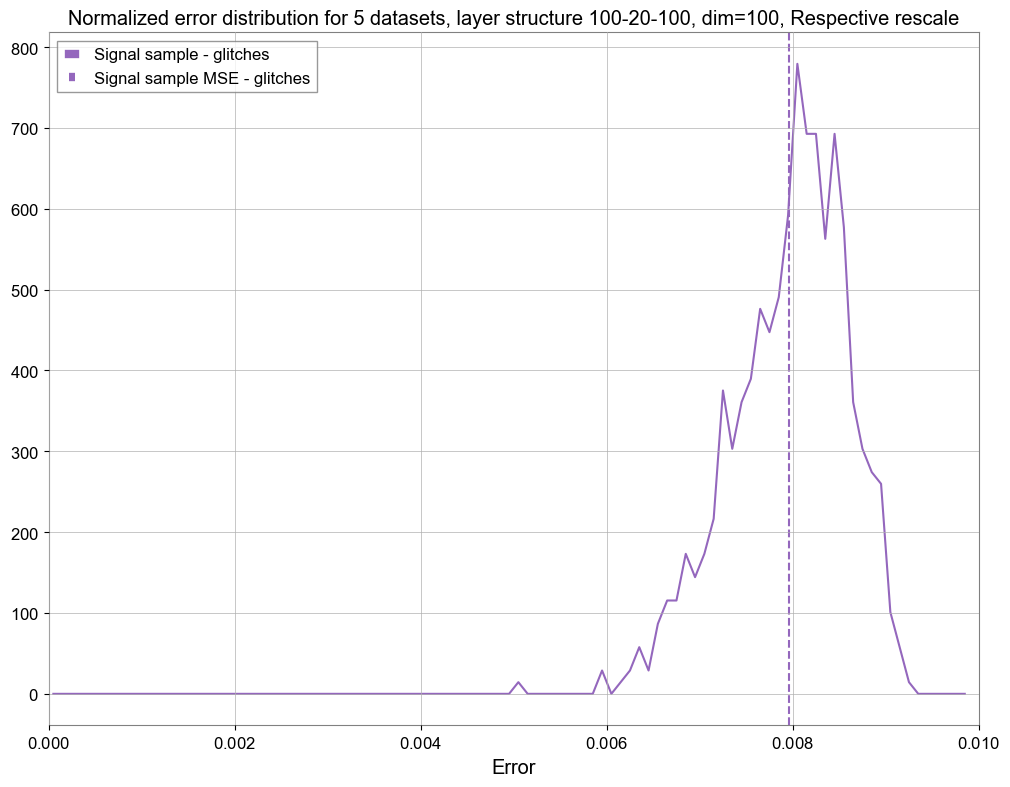

In [180]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
x_upper_limit = 1e-2

bin_scheme = np.arange(0, x_upper_limit, 1e-4)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_100d, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_100d, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_100d, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
# plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
# plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
# plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

# plt.axvline(x = MSE_train_output_100d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test_output_100d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_injected_output_100d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, x_upper_limit)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 100-20-100, dim=100, Respective rescale')
plt.legend()
plt.show()

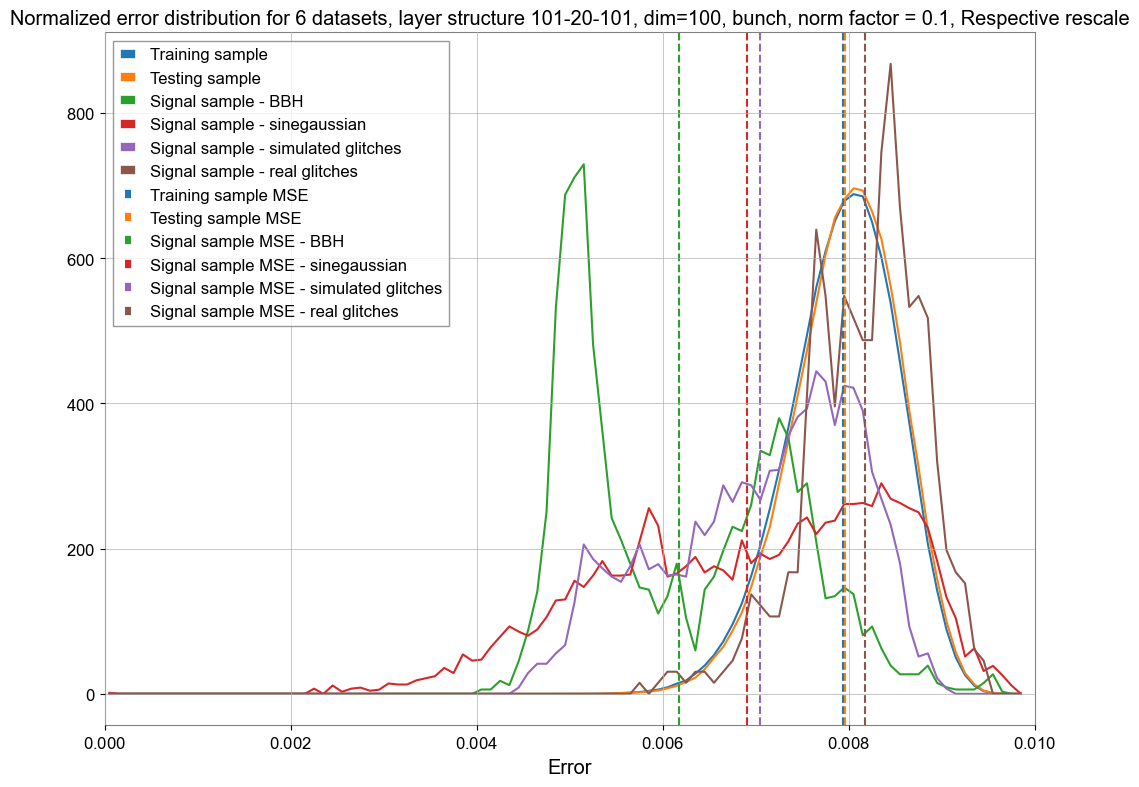

In [276]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
x_upper_limit = 1e-2

bin_scheme = np.arange(0, x_upper_limit, 1e-4)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_100d, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_100d, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_100d, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
counts_glitches_fake, bin_position_glitches_fake = np.histogram(ReconstructedError_glitches_fake_output_100d, bins = bin_scheme, density = True)
counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_100d, bins = bin_scheme, density = True)


bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches_fake = (bin_position_glitches_fake[:-1] + bin_position_glitches_fake[1:]) / 2
bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches_fake, counts_glitches_fake, color = colors[4], label = 'Signal sample - simulated glitches')
plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')

plt.axvline(x = MSE_train_output_100d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output_100d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output_100d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_fake_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
plt.axvline(x = MSE_glitches_real_output_100d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')

plt.xlim(0, x_upper_limit)
plt.xlabel('Error')
plt.title('Normalized error distribution for 6 datasets, layer structure 101-20-101, dim=100, bunch, norm factor = 0.1, Respective rescale')
plt.legend()
plt.show()

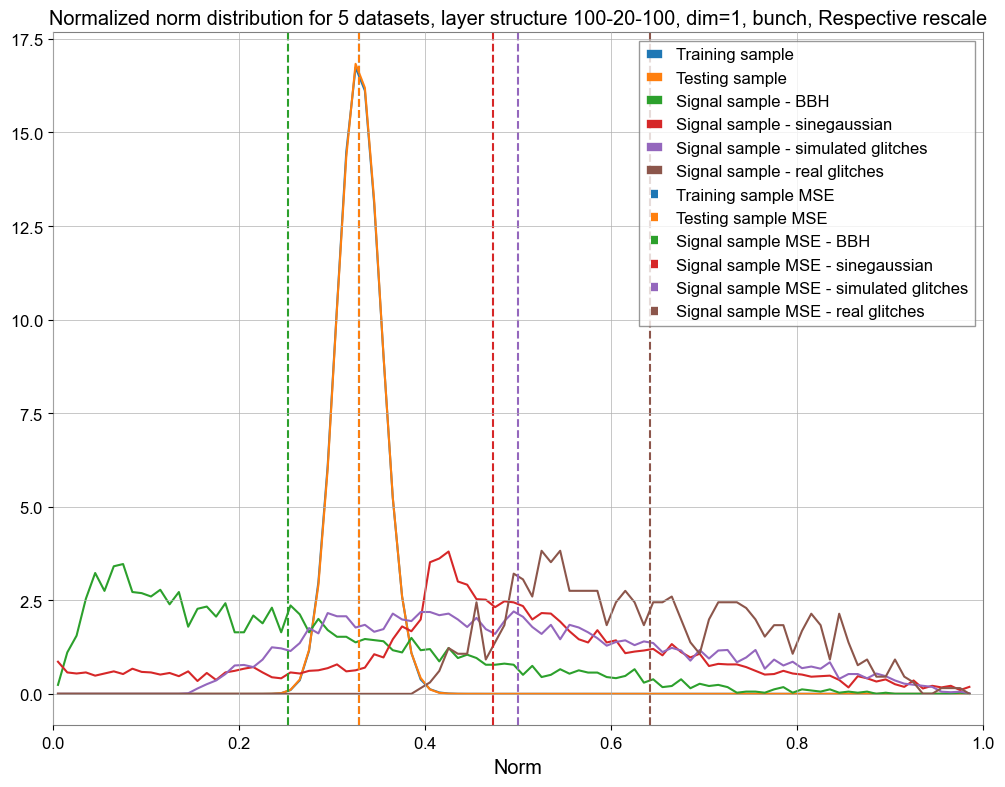

In [205]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
x_upper_limit = 1

bin_scheme = np.arange(0, x_upper_limit, 1e-2)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_1d, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_1d, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_1d, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_1d, bins = bin_scheme, density = True)
counts_glitches_fake, bin_position_glitches_fake = np.histogram(ReconstructedError_glitches_fake_output_1d, bins = bin_scheme, density = True)
counts_glitches_real, bin_position_glitches_real = np.histogram(ReconstructedError_glitches_real_output_1d, bins = bin_scheme, density = True)


bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches_fake = (bin_position_glitches_fake[:-1] + bin_position_glitches_fake[1:]) / 2
bin_centers_glitches_real = (bin_position_glitches_real[:-1] + bin_position_glitches_real[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches_fake, counts_glitches_fake, color = colors[4], label = 'Signal sample - simulated glitches')
plt.plot(bin_centers_glitches_real, counts_glitches_real, color = colors[5], label = 'Signal sample - real glitches')

plt.axvline(x = MSE_train_output_1d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output_1d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output_1d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output_1d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_fake_output_1d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - simulated glitches')
plt.axvline(x = MSE_glitches_real_output_1d, color = colors[5], linestyle = '--', label = 'Signal sample MSE - real glitches')

plt.xlim(0, x_upper_limit)
plt.xlabel('Norm')
plt.title('Normalized norm distribution for 5 datasets, layer structure 100-20-100, dim=1, bunch, Respective rescale')
plt.legend()
plt.show()

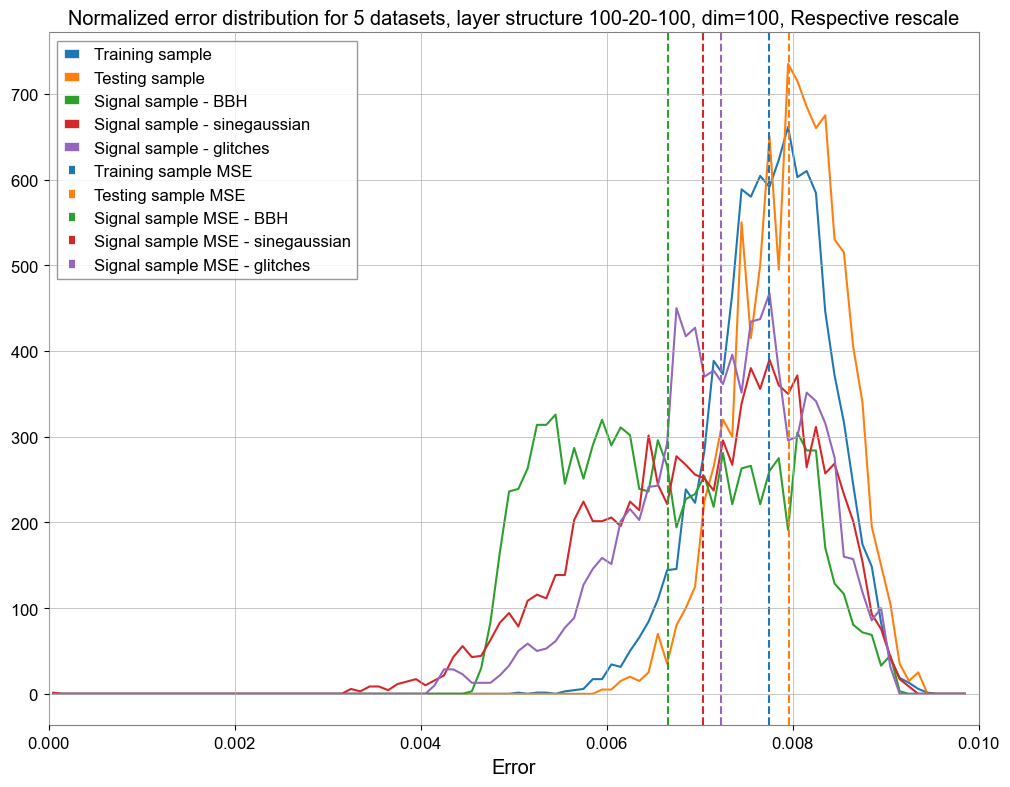

In [164]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
x_upper_limit = 1e-2

bin_scheme = np.arange(0, x_upper_limit, 1e-4)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_100d, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_100d, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_100d, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_100d, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_100d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

plt.axvline(x = MSE_train_output_100d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test_output_100d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_injected_output_100d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_sinegaussian_output_100d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_glitches_output_100d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, x_upper_limit)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, layer structure 100-20-100, dim=100, Respective rescale')
plt.legend()
plt.show()

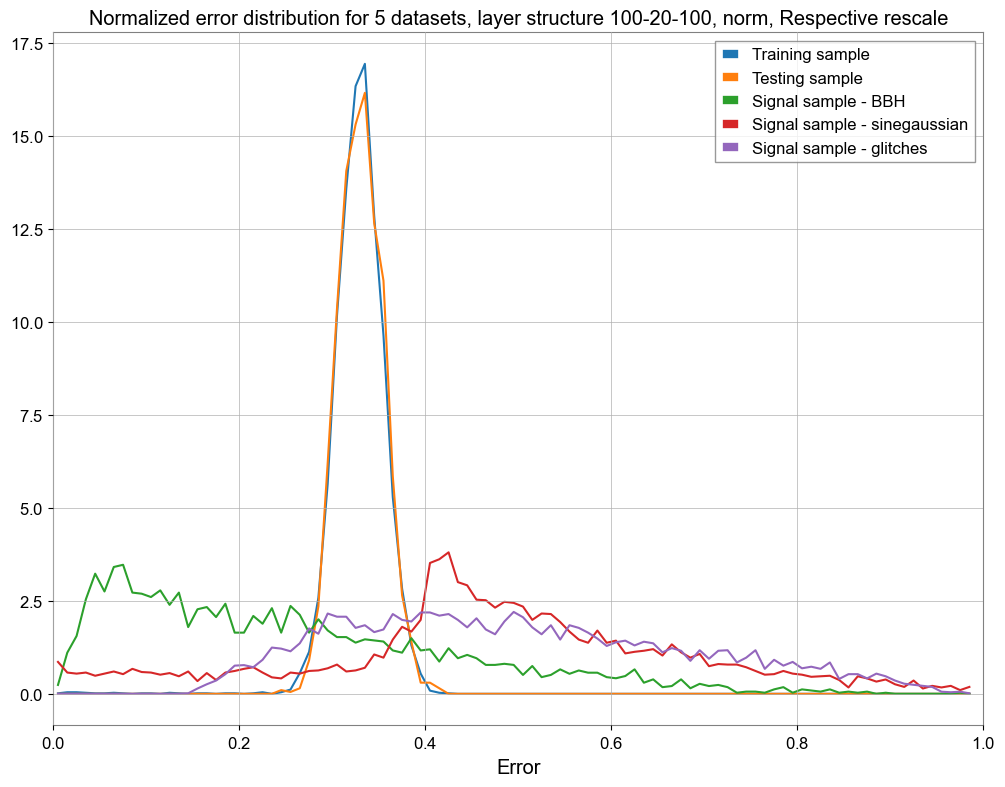

In [165]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bin_scheme = np.arange(0,1,1e-2)

# bin_scheme = generate_custom_bins(1e-7, 1e-1, 1e-7)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_1d, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_1d, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_1d, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_1d, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_1d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

# plt.axvline(x = MSE_train_output_1d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test_output_1d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_injected_output_1d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output_1d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_1d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 1)
# plt.ylim()
plt.xlabel('Error')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Norm distribution for 5 datasets, layer structure 100-20-100, Respective rescale')
plt.legend()
plt.show()

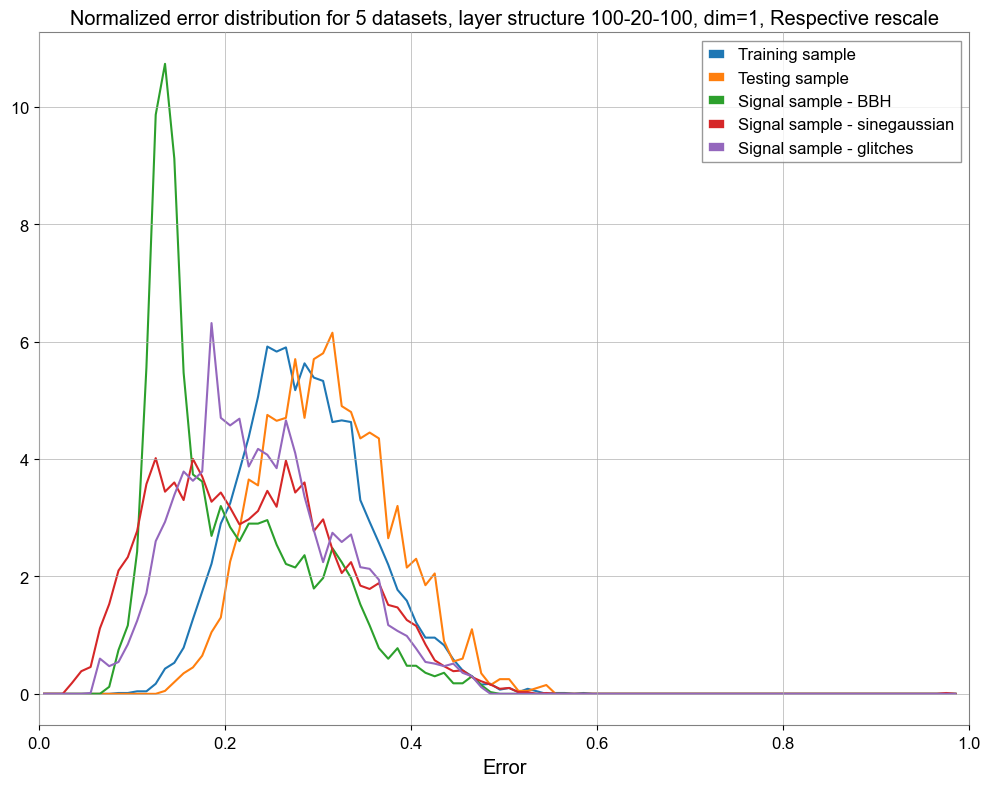

In [113]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bin_scheme = np.arange(0,1,1e-2)

# bin_scheme = generate_custom_bins(1e-7, 1e-1, 1e-7)

counts_train, bin_position_train = np.histogram(ReconstructedError_train_output_1d, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test_output_1d, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_injected_output_1d, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_sinegaussian_output_1d, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches_output_1d, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'Signal sample - glitches')

# plt.axvline(x = MSE_train_output_1d, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test_output_1d, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_injected_output_1d, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_sinegaussian_output_1d, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches_output_1d, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')

plt.xlim(0, 1)
# plt.ylim()
plt.xlabel('Error')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Normalized error distribution for 5 datasets, layer structure 100-20-100, dim=1, Respective rescale')
plt.legend()
plt.show()

In [350]:
max(ReconstructedError_test_output_100d)

0.0112100913342482

In [374]:
np.sort(ReconstructedError_train_output_100d)[-700]

0.009622968915763197

In [375]:
np.argwhere(ReconstructedError_injected_output_100d > 0.009622968915763197).shape[0] / len(ReconstructedError_injected_output_100d)

0.5364614465032875

FPR-TPR processing Unit
----

In [69]:
bins_x = np.arange(0, 0.02, 1e-4)
bins_y = np.logspace(-9, 0, num = 200)

In [151]:
bins_x = np.arange(0, 0.01, 1e-4)
bins_y = np.arange(0,1.25,1e-2)

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\2584497344.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


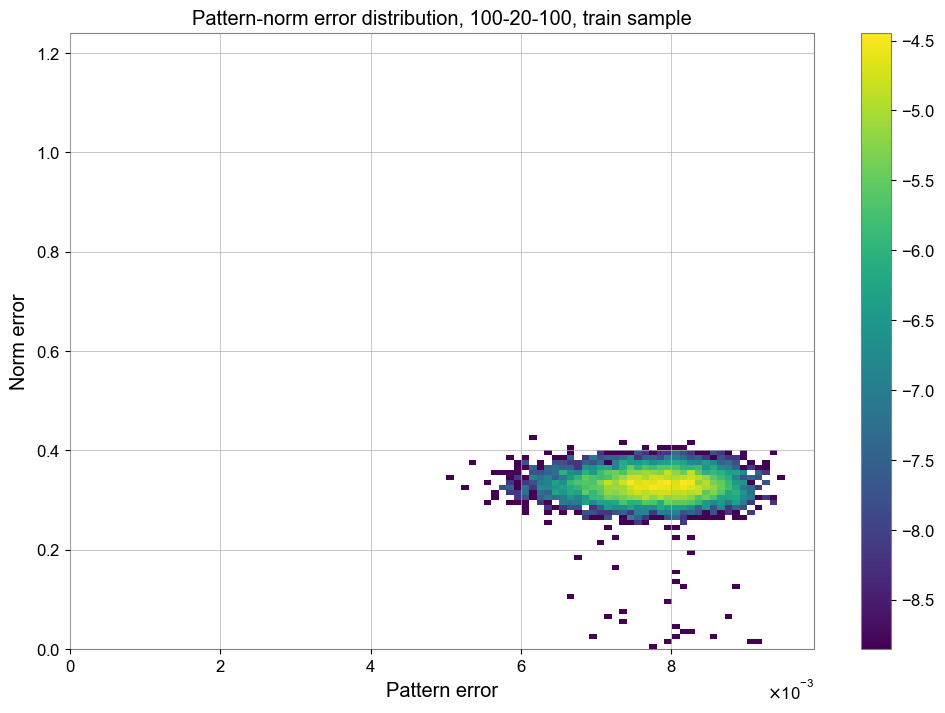

In [152]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_train_output_100d,ReconstructedError_train_output_1d, bins=[bins_x, bins_y])


hist = hist / hist.sum()
hist= np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])

plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 100-20-100, train sample')
plt.xlabel('Pattern error')
plt.ylabel("Norm error")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])


# 显示图形
plt.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\4127449443.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


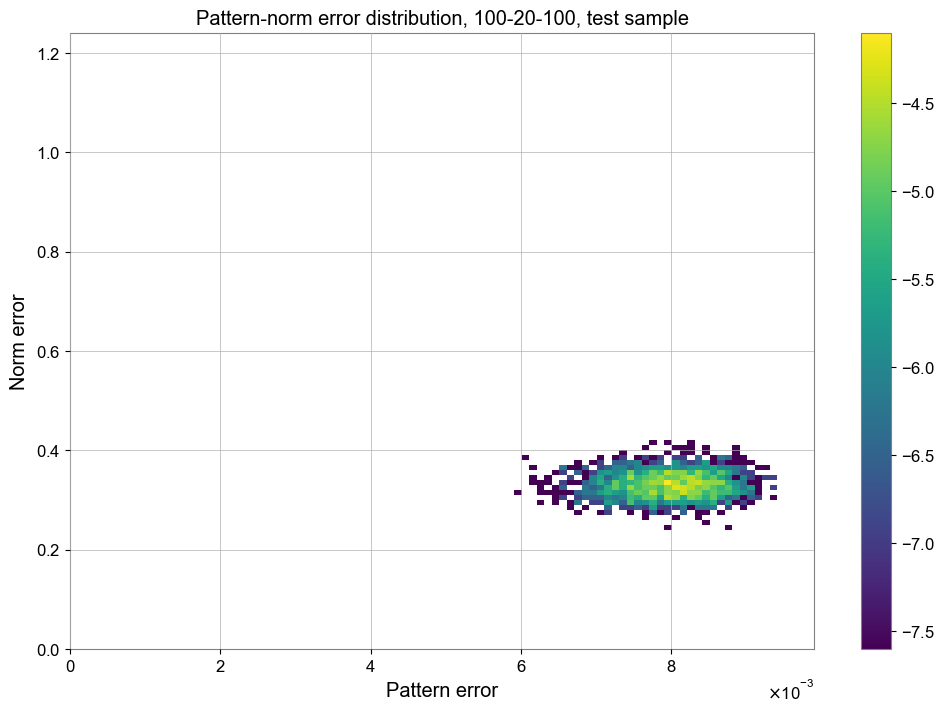

In [153]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_test_output_100d,ReconstructedError_test_output_1d, bins=[bins_x, bins_y])


hist = hist / hist.sum()
hist= np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])

plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 100-20-100, test sample')
plt.xlabel('Pattern error')
plt.ylabel("Norm error")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])


# 显示图形
plt.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\1724613635.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


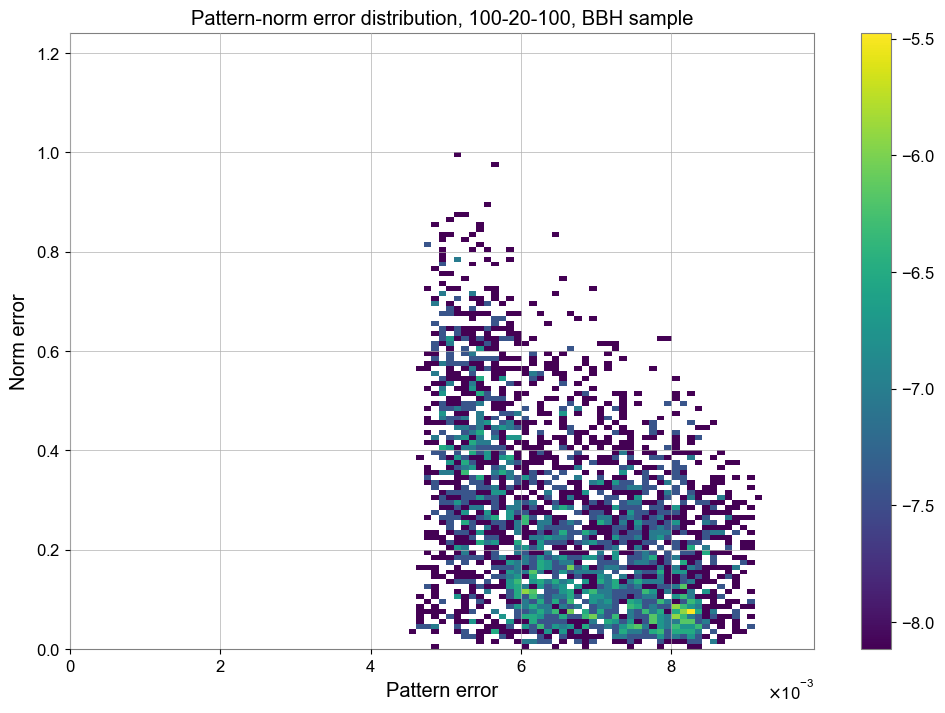

In [154]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_injected_output_100d,ReconstructedError_injected_output_1d, bins=[bins_x, bins_y])


hist = hist / hist.sum()
hist= np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])

plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 100-20-100, BBH sample')
plt.xlabel('Pattern error')
plt.ylabel("Norm error")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])


# 显示图形
plt.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\2154826427.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


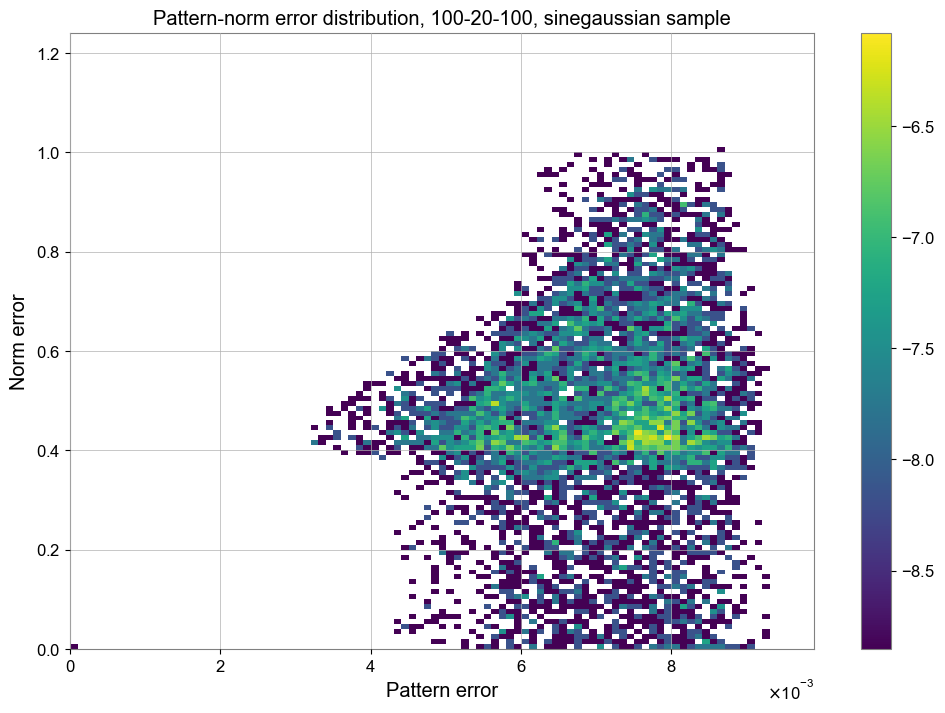

In [155]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_sinegaussian_output_100d,ReconstructedError_sinegaussian_output_1d, bins=[bins_x, bins_y])


hist = hist / hist.sum()
hist= np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])

plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 100-20-100, sinegaussian sample')
plt.xlabel('Pattern error')
plt.ylabel("Norm error")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])


# 显示图形
plt.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\1269098908.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


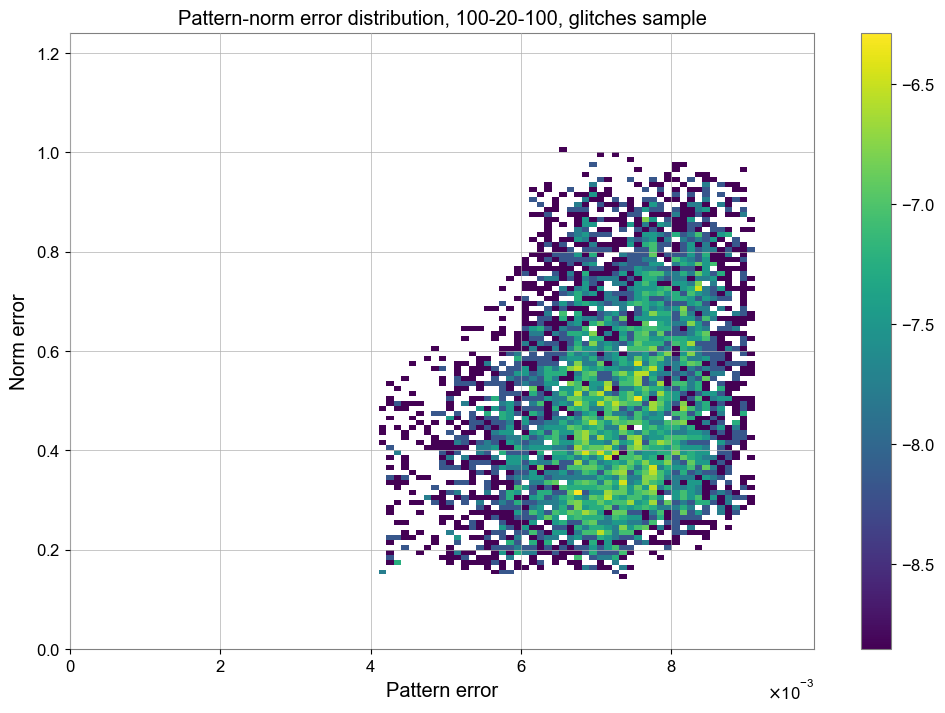

In [156]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_glitches_output_100d,ReconstructedError_glitches_output_1d, bins=[bins_x, bins_y])


hist = hist / hist.sum()
hist= np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])

plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 100-20-100, glitches sample')
plt.xlabel('Pattern error')
plt.ylabel("Norm error")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])


# 显示图形
plt.show()

C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\246768986.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


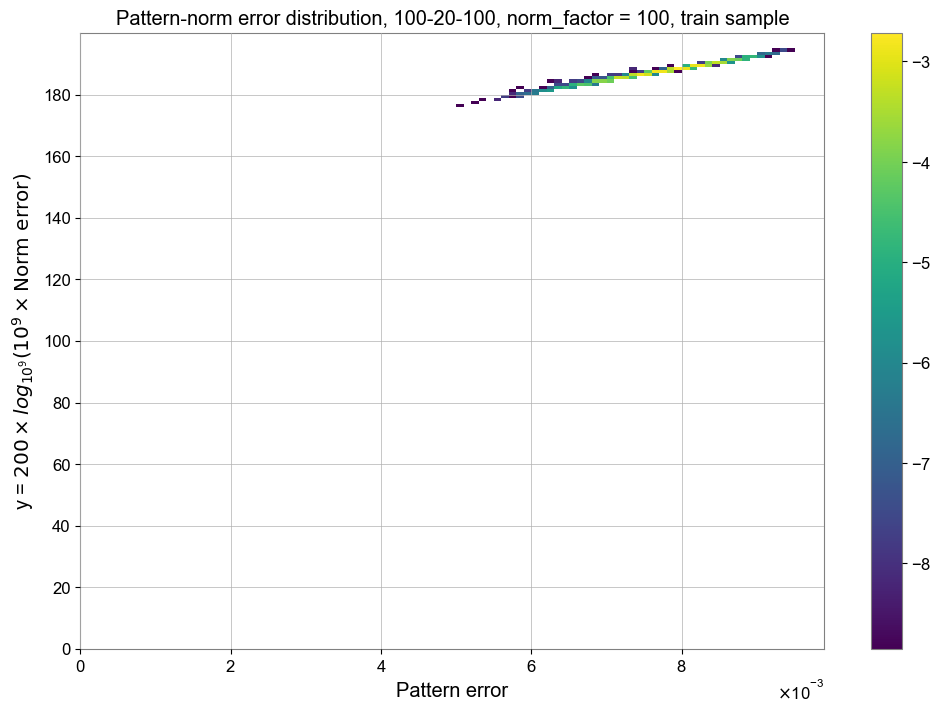

In [71]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_train_output_100d,ReconstructedError_train_output_1d, bins=[bins_x, bins_y])


hist = hist / hist.sum()
hist= np.log(hist)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])

plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 100-20-100, norm_factor = 100, train sample')
plt.xlabel('Pattern error')
plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\mathrm{Norm \\ error})$")
plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])


# 显示图形
plt.show()

In [153]:
def FPR_mask(hist, FPR):
    hist_sorted = np.sort(hist, axis=None)

    total_hist_sum = hist_sorted.sum()
    threshold = int(FPR * total_hist_sum)

    sum = hist_sorted[0]
    i = 0
    while(sum < threshold):
        i += 1
        sum += hist_sorted[i]
    
    mask = np.argwhere(hist > hist_sorted[i])

    mask_Boolen = np.zeros((hist.shape[0], hist.shape[1]), dtype=bool)
    mask_Boolen[mask[:, 0], mask[:, 1]] = True

    return mask_Boolen

In [154]:
def Mask_and_TPR_computing(hist, mask):

    hist_masked = hist.copy()
    hist_masked[mask] = 0
    denominator = hist.sum()
    numerator = hist_masked.sum()

    print(numerator, denominator)

    return hist_masked, numerator/denominator

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_80038/2376776724.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


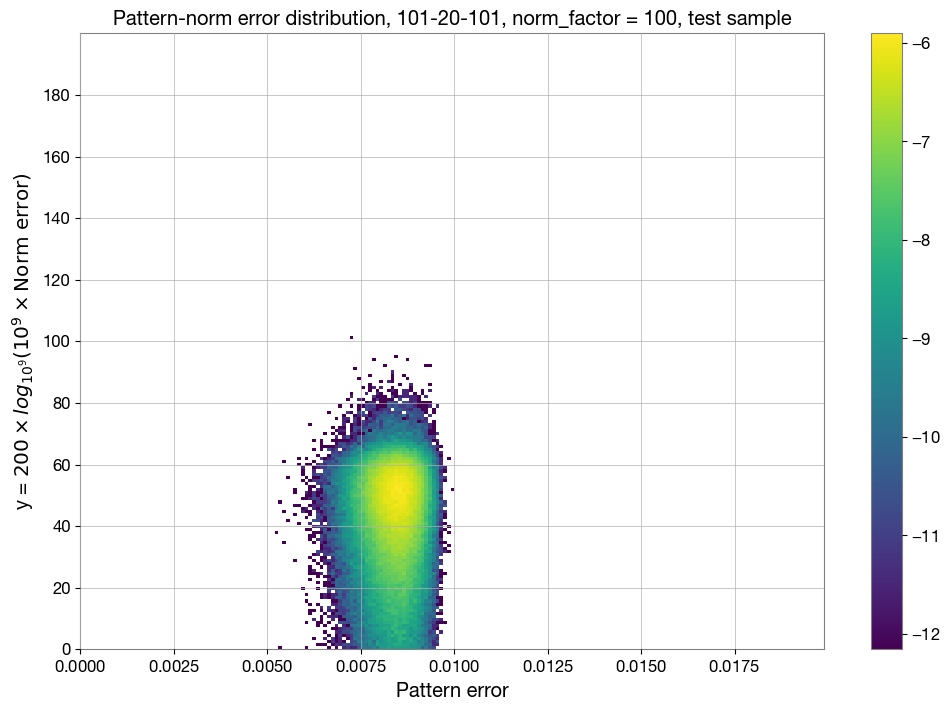

In [123]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_test_output_100d,ReconstructedError_test_output_1d, bins=[bins_x, bins_y])
# hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)
hist = hist/ hist.sum()

hist= np.log(hist)

# print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, test sample')
plt.xlabel('Pattern error')
plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\mathrm{Norm \\ error})$")
plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_80038/2941920766.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


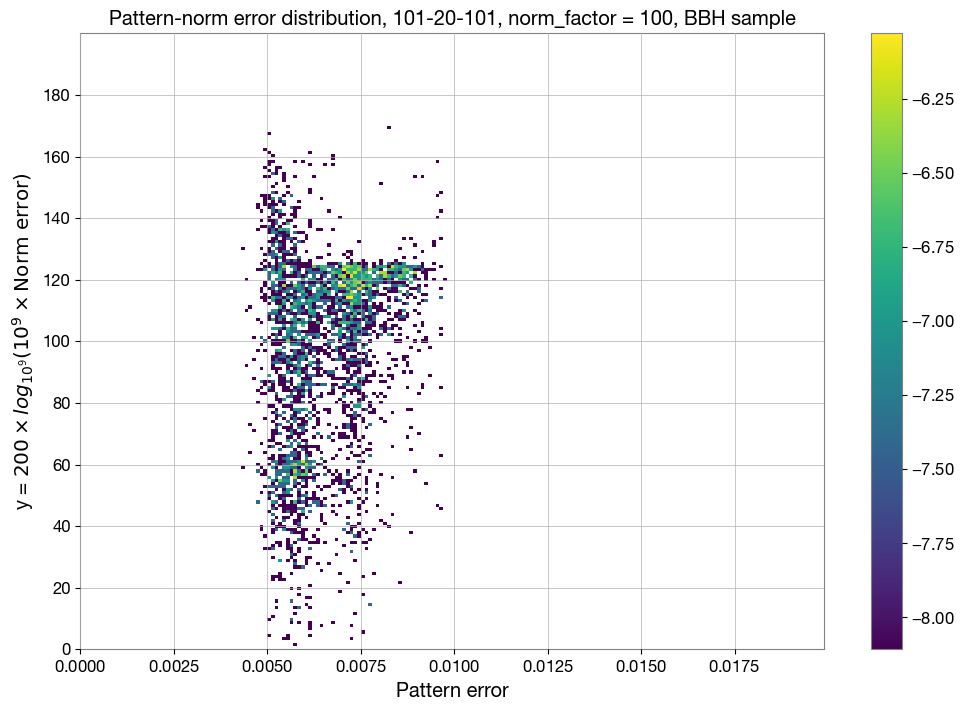

In [124]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_injected_output_100d,ReconstructedError_injected_output_1d, bins=[bins_x, bins_y])
# hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)
hist = hist / hist.sum()

hist= np.log(hist)

# print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(12, 8)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, BBH sample')
plt.xlabel('Pattern error')
plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\mathrm{Norm\\ error})$")
plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_80038/2168870476.py:6: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


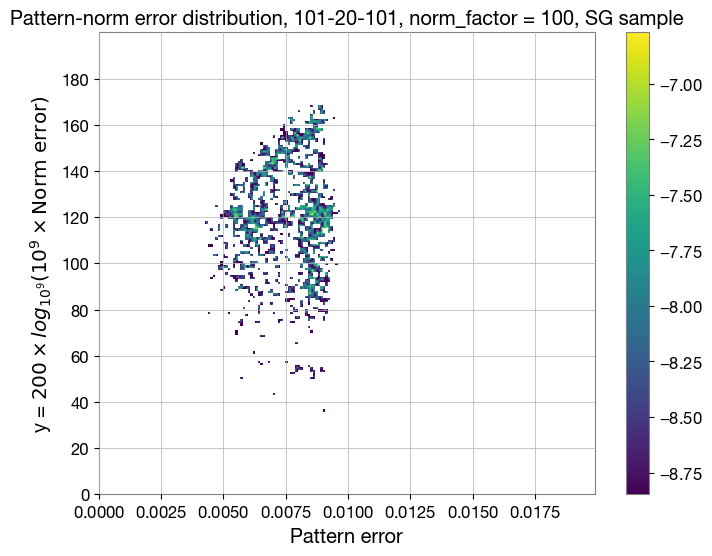

In [125]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_sinegaussian_output_100d,ReconstructedError_sinegaussian_output_1d, bins=[bins_x, bins_y])
# hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)

hist = hist / hist.sum()

hist= np.log(hist)

# print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, SG sample')
plt.xlabel('Pattern error')
plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\mathrm{Norm \\ error})$")
plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

/var/folders/2v/3ndz_6mx79z7p4z3mfgc3kvc0000gn/T/ipykernel_80038/2017134376.py:5: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


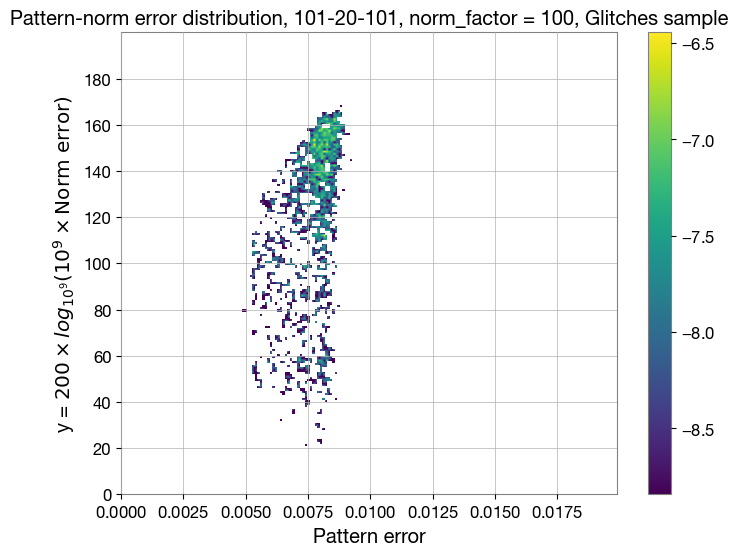

In [126]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_glitches_output_100d,ReconstructedError_glitches_output_1d, bins=[bins_x, bins_y])
# hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)
hist = hist / hist.sum()

hist= np.log(hist)

# print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 100, Glitches sample')
plt.xlabel('Pattern error')
plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\mathrm{Norm \\ error})$")
plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形

plt.show()

In [94]:
# mask for the data sample
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_train_output_100d,ReconstructedError_train_output_1d, bins=[bins_x, bins_y])
hist_bunch_noise = hist

In [98]:
mask = FPR_mask(hist_bunch_noise, 0.001)

In [99]:
mask.shape

(99, 79)

40.0 7000.0
0.005714285714285714


C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\1919935356.py:4: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


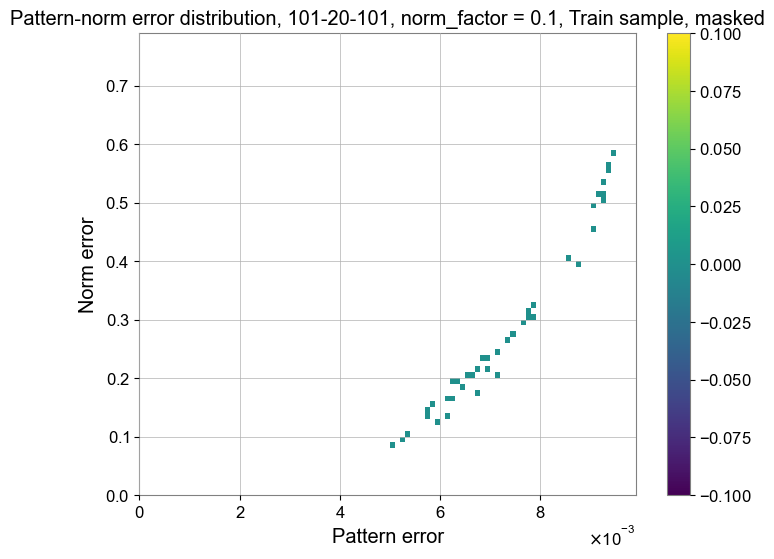

In [103]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_train_output_100d,ReconstructedError_train_output_1d, bins=[bins_x, bins_y])
hist, TPR_Train = Mask_and_TPR_computing(hist, mask)

hist= np.log(hist)

print(TPR_Train)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 0.1, Train sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
# plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\text{Norm error})$")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

17.0 2000.0
0.0085


C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\4133776235.py:4: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


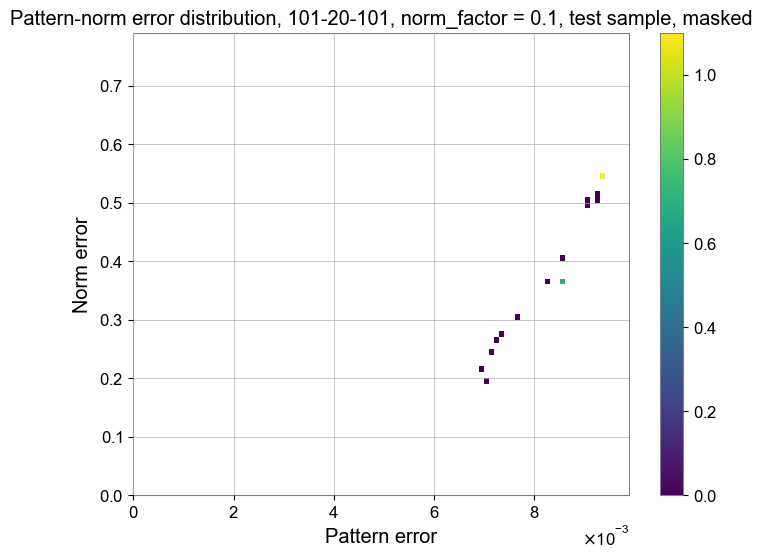

In [104]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_test_output_100d,ReconstructedError_test_output_1d, bins=[bins_x, bins_y])
hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)

hist= np.log(hist)

print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 0.1, test sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
# plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\text{Norm error})$")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

967.0 3346.0
0.2890017931858936


C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\3950332688.py:4: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


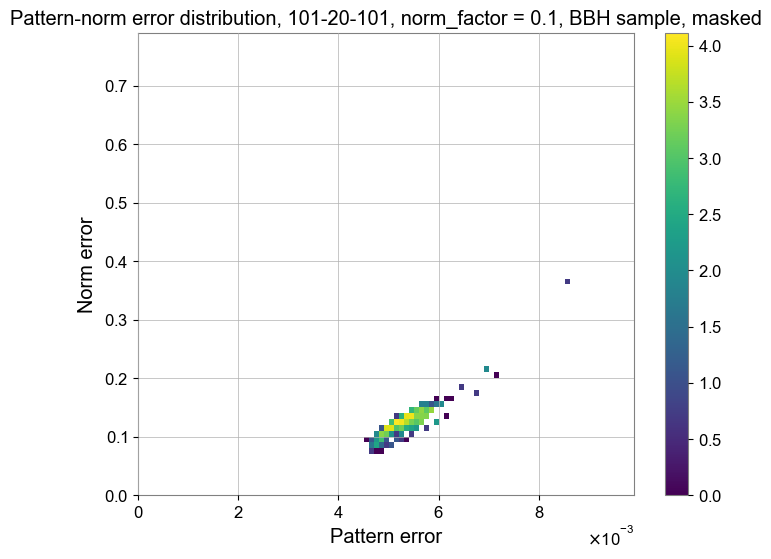

In [105]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_injected_output_100d,ReconstructedError_injected_output_1d, bins=[bins_x, bins_y])
hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)

hist= np.log(hist)

print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 0.1, BBH sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
# plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\text{Norm error})$")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

1008.0 6999.0
0.14402057436776683


C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\3076558440.py:4: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


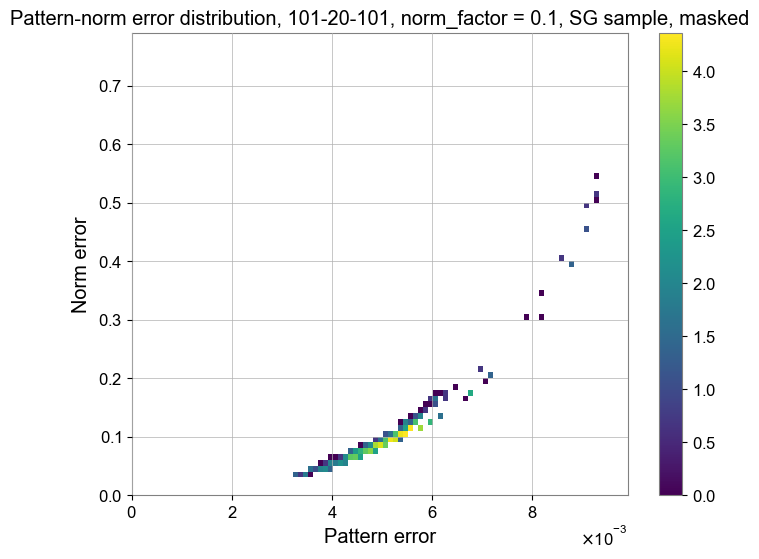

In [106]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_sinegaussian_output_100d,ReconstructedError_sinegaussian_output_1d, bins=[bins_x, bins_y])
hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)

hist= np.log(hist)

print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 0.1, SG sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
# plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\text{Norm error})$")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

639.0 7000.0
0.09128571428571429


C:\Users\Liyang Miao\AppData\Local\Temp\ipykernel_30152\2330546892.py:4: RuntimeWarning: divide by zero encountered in log
  hist= np.log(hist)


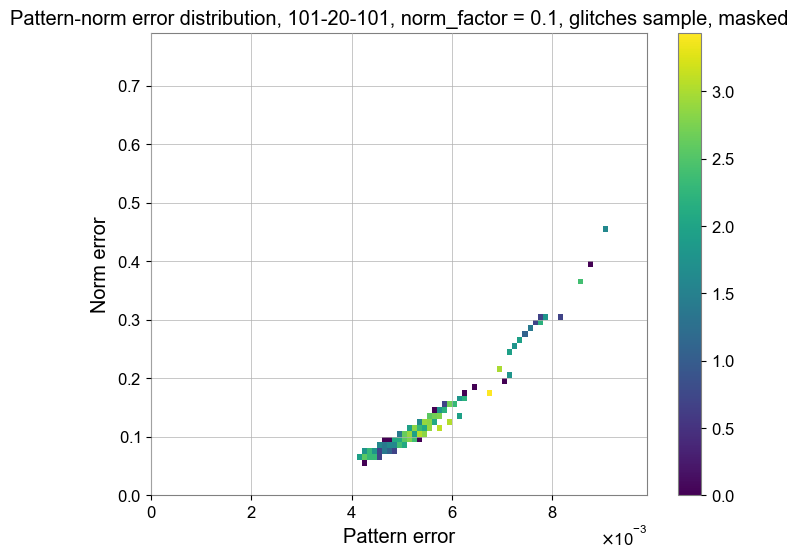

In [107]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_glitches_output_100d,ReconstructedError_glitches_output_1d, bins=[bins_x, bins_y])
hist, TPR_BBH = Mask_and_TPR_computing(hist, mask)

hist= np.log(hist)

print(TPR_BBH)

# 可视化二维直方图
aspect_ratio = (bins_x[-1]-bins_x[0])/(bins_y[-1] - bins_y[0])
plt.figure(figsize=(8, 6)) 
plt.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
plt.colorbar()

# 添加标题和轴标签
plt.title('Pattern-norm error distribution, 101-20-101, norm_factor = 0.1, glitches sample, masked')
plt.xlabel('Pattern error')
plt.ylabel('Norm error')
# plt.ylabel("y = $200 \\times log_{10^9}(10^9 \\times \\text{Norm error})$")
# plt.yticks(np.arange(0,1,1/10), np.arange(0, 200, 20))
plt.xscale('linear')
# plt.yscale('log')
plt.xlim(0, bins_x[-1])

# 显示图形
plt.show()

In [148]:
FPR_list = np.logspace(-3, 0, 30)

In [160]:
TPR_1000_test_list = []
TPR_1000_BBH_list = []
TPR_1000_SG_list = []
TPR_1000_Glitches_list = []

In [224]:
TPR_100_test_list = []
TPR_100_BBH_list = []
TPR_100_SG_list = []
TPR_100_Glitches_list = []
TPR_100_Glitches_real_list = []

In [438]:
TPR_10_test_list = []
TPR_10_BBH_list = []
TPR_10_SG_list = []
TPR_10_Glitches_list = []

In [458]:
TPR_1_test_list = []
TPR_1_BBH_list = []
TPR_1_SG_list = []
TPR_1_Glitches_list = []

In [477]:
TPR_01_test_list = []
TPR_01_BBH_list = []
TPR_01_SG_list = []
TPR_01_Glitches_list = []

In [225]:
hist, x_edges, y_edges = np.histogram2d(ReconstructedError_train_output_100d,ReconstructedError_train_output_1d, bins=[bins_x, bins_y])
hist_bunch_noise = hist

for FPR in FPR_list:
    mask = FPR_mask(hist_bunch_noise, FPR)

    hist_test, _, _ = np.histogram2d(ReconstructedError_test_output_100d,ReconstructedError_test_output_1d, bins=[bins_x, bins_y])
    hist_BBH, _, _ = np.histogram2d(ReconstructedError_injected_output_100d,ReconstructedError_injected_output_1d, bins=[bins_x, bins_y])
    hist_SG, _, _ = np.histogram2d(ReconstructedError_sinegaussian_output_100d,ReconstructedError_sinegaussian_output_1d, bins=[bins_x, bins_y])
    hist_Glitches, _, _ = np.histogram2d(ReconstructedError_glitches_fake_output_100d,ReconstructedError_glitches_fake_output_1d, bins=[bins_x, bins_y])
    hist_Glitches_real, _, _ = np.histogram2d(ReconstructedError_glitches_real_output_100d,ReconstructedError_glitches_real_output_1d, bins=[bins_x, bins_y])

    _, TPR_test = Mask_and_TPR_computing(hist_test, mask)
    _, TPR_BBH = Mask_and_TPR_computing(hist_BBH, mask)
    _, TPR_SG = Mask_and_TPR_computing(hist_SG, mask)
    _, TPR_Glitches = Mask_and_TPR_computing(hist_Glitches, mask)
    _, TPR_Glitches_real = Mask_and_TPR_computing(hist_Glitches_real, mask)

    TPR_100_test_list.append(TPR_test)
    TPR_100_BBH_list.append(TPR_BBH)
    TPR_100_SG_list.append(TPR_SG)
    TPR_100_Glitches_list.append(TPR_Glitches)
    TPR_100_Glitches_real_list.append(TPR_Glitches_real)

213.0 200000.0
3104.0 3346.0
6058.0 7000.0
5418.0 7000.0
651.0 657.0
242.0 200000.0
3113.0 3346.0
6086.0 7000.0
5450.0 7000.0
652.0 657.0
310.0 200000.0
3128.0 3346.0
6118.0 7000.0
5503.0 7000.0
652.0 657.0
402.0 200000.0
3152.0 3346.0
6166.0 7000.0
5551.0 7000.0
654.0 657.0
474.0 200000.0
3162.0 3346.0
6198.0 7000.0
5592.0 7000.0
654.0 657.0
609.0 200000.0
3176.0 3346.0
6227.0 7000.0
5644.0 7000.0
654.0 657.0
779.0 200000.0
3182.0 3346.0
6254.0 7000.0
5674.0 7000.0
654.0 657.0
1027.0 200000.0
3188.0 3346.0
6285.0 7000.0
5725.0 7000.0
654.0 657.0
1268.0 200000.0
3190.0 3346.0
6335.0 7000.0
5768.0 7000.0
656.0 657.0
1639.0 200000.0
3201.0 3346.0
6383.0 7000.0
5825.0 7000.0
656.0 657.0
2080.0 200000.0
3209.0 3346.0
6419.0 7000.0
5882.0 7000.0
656.0 657.0
2709.0 200000.0
3223.0 3346.0
6449.0 7000.0
5926.0 7000.0
657.0 657.0
3454.0 200000.0
3228.0 3346.0
6480.0 7000.0
5977.0 7000.0
657.0 657.0
4360.0 200000.0
3230.0 3346.0
6510.0 7000.0
6012.0 7000.0
657.0 657.0
5463.0 200000.0
3239.0 3346

In [157]:
TPR_100_test_list

[0.001065,
 0.00121,
 0.00155,
 0.00201,
 0.00237,
 0.003045,
 0.003895,
 0.005135,
 0.00634,
 0.008195,
 0.0104,
 0.013545,
 0.01727,
 0.0218,
 0.027315,
 0.03477,
 0.04435,
 0.056575,
 0.072065,
 0.092535,
 0.11696,
 0.14655,
 0.18761,
 0.23814,
 0.301525,
 0.385275,
 0.49045,
 0.62214,
 0.789295,
 1.0]

In [385]:
TPR_1000_BBH_list

[0.7878162106350026,
 0.7986577181208053,
 0.7986577181208053,
 0.8043366029943211,
 0.8074341765616934,
 0.8100154878678368,
 0.8162106350025813,
 0.8249870934434693,
 0.8280846670108415,
 0.8337635518843572,
 0.8363448631905007,
 0.8415074858027878,
 0.8477026329375322,
 0.8508002065049045,
 0.8590604026845637,
 0.862157976251936,
 0.8662880743417656,
 0.8709344346928239,
 0.8771295818275684,
 0.8828084667010841,
 0.8890036138358286,
 0.8946824987093444,
 0.9024264326277749,
 0.9112028910686629,
 0.9220443985544656,
 0.9313371192565824,
 0.9478575116159009,
 0.963345379452762,
 0.9803820340733093,
 0.7878162106350026,
 0.7986577181208053,
 0.7986577181208053,
 0.8043366029943211,
 0.8074341765616934,
 0.8100154878678368,
 0.8162106350025813,
 0.8249870934434693,
 0.8280846670108415,
 0.8337635518843572,
 0.8363448631905007,
 0.8415074858027878,
 0.8477026329375322,
 0.8508002065049045,
 0.8580278781621063,
 0.8611254517294786,
 0.8662880743417656,
 0.8709344346928239,
 0.877129581827

Text(0.5, 1.0, 'SOC curve for 100-20-100 scheme')

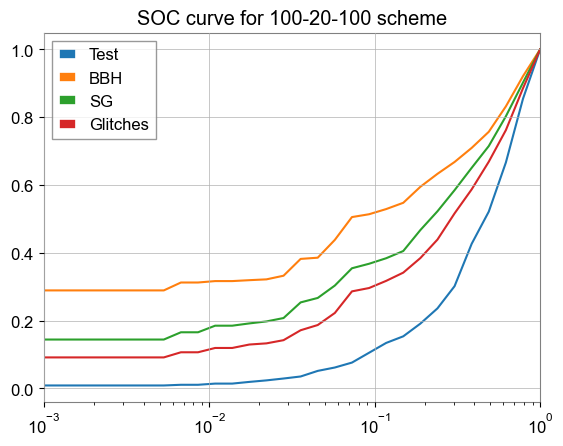

In [112]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', ]

plt.plot(FPR_list, TPR_1000_test_list, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_1000_BBH_list, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_1000_SG_list, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_1000_Glitches_list, color = colors[3], label = 'Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('SOC curve for 100-20-100 scheme')

Text(0.5, 1.0, 'ROC curve for 100-20-100 scheme, pattern error-norm')

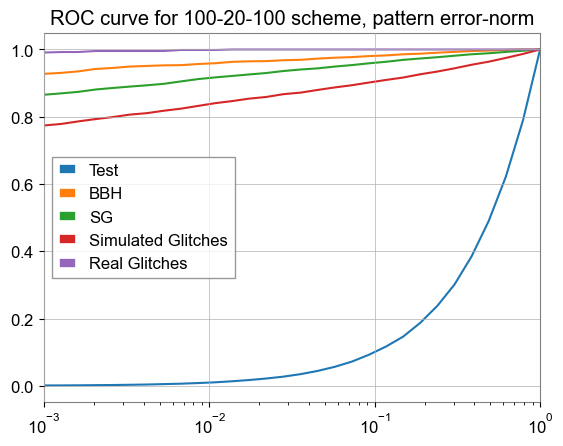

In [226]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b']

plt.plot(FPR_list, TPR_100_test_list, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_100_BBH_list, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_100_SG_list, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_100_Glitches_list, color = colors[3], label = 'Simulated Glitches')
plt.plot(FPR_list, TPR_100_Glitches_real_list, color = colors[4], label = 'Real Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for 100-20-100 scheme, pattern error-norm')

Text(0.5, 1.0, 'SOC curve for norm factor = 10')

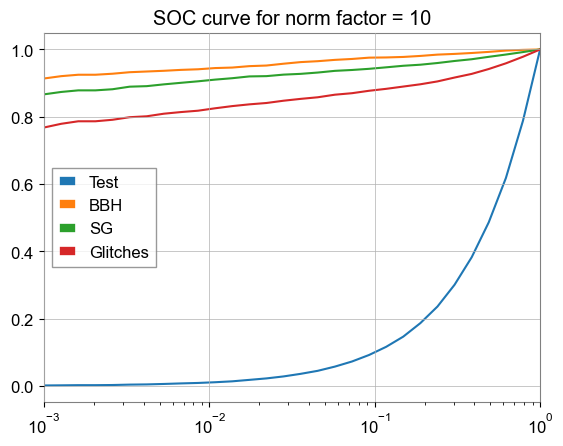

In [440]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.plot(FPR_list, TPR_10_test_list, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_10_BBH_list, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_10_SG_list, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_10_Glitches_list, color = colors[3], label = 'Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('SOC curve for norm factor = 10')

Text(0.5, 1.0, 'SOC curve for norm factor = 1')

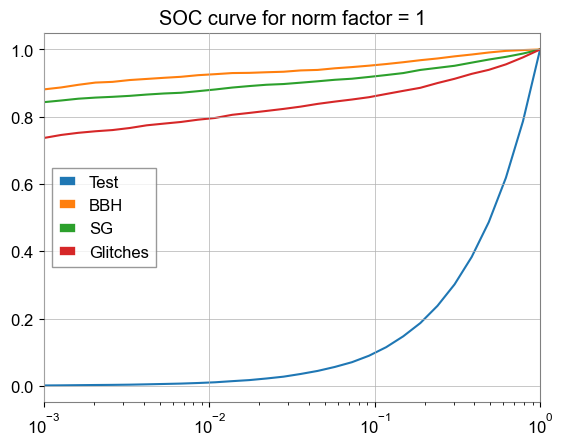

In [460]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.plot(FPR_list, TPR_1_test_list, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_1_BBH_list, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_1_SG_list, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_1_Glitches_list, color = colors[3], label = 'Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('SOC curve for norm factor = 1')

Text(0.5, 1.0, 'SOC curve for norm factor = 0.1')

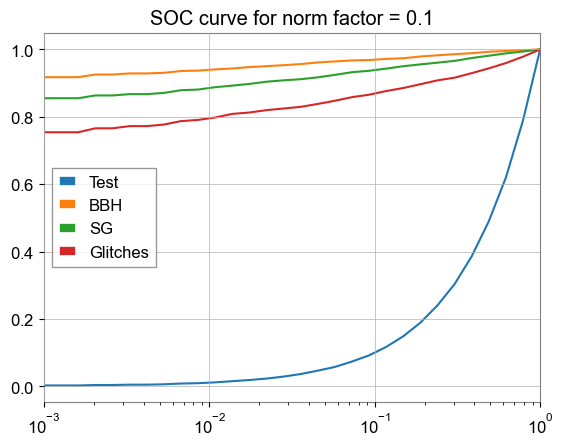

In [479]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.plot(FPR_list, TPR_01_test_list, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_01_BBH_list, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_01_SG_list, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_01_Glitches_list, color = colors[3], label = 'Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('SOC curve for norm factor = 0.1')

In [71]:
def upperTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        threshold = np.sort(trainerror)[-index_number]
            
        # print(threshold)
        # print(np.argwhere(signalerror > threshold).shape)
        TPRlist[i] = np.argwhere(signalerror > threshold).shape[0] / length_of_signal_value
    
    return TPRlist

In [72]:
def lowerTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        if index_number == 0:
            threshold = np.sort(trainerror)[index_number]
        else:
            threshold = np.sort(trainerror)[index_number-1]
        # print(np.sort(trainerror))
        # print(threshold)
        # print(np.argwhere(signalerror < threshold).shape)
        TPRlist[i] = np.argwhere(signalerror < threshold).shape[0] / length_of_signal_value
    
    return TPRlist

(array([ 41.,  84., 129.,  93.,  78.,  88.,  66.,  55.,  17.,
          6.]),
 array([0.39649771, 0.45684794, 0.51719817, 0.57754839,
        0.63789862, 0.69824885, 0.75859908, 0.81894931,
        0.87929954, 0.93964977, 1.        ]),
 <BarContainer object of 10 artists>)

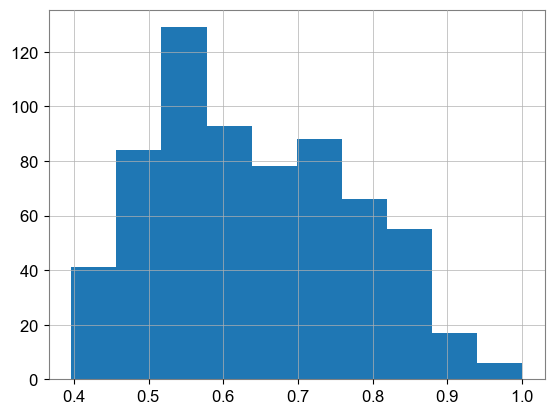

In [221]:
plt.hist(ReconstructedError_glitches_real_output_1d)

In [218]:
-len(ReconstructedError_train_output_1d) * 0.001

-700.0

In [219]:
np.sort(ReconstructedError_train_output_1d)[-700]

0.40450696265572017

In [220]:
np.argwhere(ReconstructedError_glitches_real_output_1d > 0.40450696265572017).shape

(655, 1)

In [277]:
FPR_list = np.logspace(-3,0,30)

In [285]:
TPR_list_test = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_test_output_100d.flatten(), FPR_list)
TPR_list_BBH = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_injected_output_100d.flatten(), FPR_list)
TPR_list_SG = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_sinegaussian_output_100d.flatten(), FPR_list)
TPR_list_real_glitches = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_real_output_100d.flatten(), FPR_list)
TPR_list_fake_glitches = upperTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_fake_output_100d.flatten(), FPR_list)

In [281]:
TPR_list_test = lowerTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_test_output_100d.flatten(), FPR_list)
TPR_list_BBH = lowerTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_injected_output_100d.flatten(), FPR_list)
TPR_list_SG = lowerTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_sinegaussian_output_100d.flatten(), FPR_list)
TPR_list_real_glitches = lowerTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_real_output_100d.flatten(), FPR_list)
TPR_list_fake_glitches = lowerTPRFPRcalc(ReconstructedError_train_output_100d.flatten(), ReconstructedError_glitches_fake_output_100d.flatten(), FPR_list)

In [286]:
TPR_list_test = upperTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_test_output_1d.flatten(), FPR_list)
TPR_list_BBH = upperTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_injected_output_1d.flatten(), FPR_list)
TPR_list_SG = upperTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_sinegaussian_output_1d.flatten(), FPR_list)
TPR_list_real_glitches = upperTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_glitches_real_output_1d.flatten(), FPR_list)
TPR_list_fake_glitches = upperTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_glitches_fake_output_1d.flatten(), FPR_list)

In [289]:
TPR_list_test = lowerTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_test_output_1d.flatten(), FPR_list)
TPR_list_BBH = lowerTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_injected_output_1d.flatten(), FPR_list)
TPR_list_SG = lowerTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_sinegaussian_output_1d.flatten(), FPR_list)
TPR_list_real_glitches = lowerTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_glitches_real_output_1d.flatten(), FPR_list)
TPR_list_fake_glitches = lowerTPRFPRcalc(ReconstructedError_train_output_1d.flatten(), ReconstructedError_glitches_fake_output_1d.flatten(), FPR_list)

In [290]:
TPR_list_test[-1] = 1
TPR_list_BBH[-1] = 1
TPR_list_SG[-1] = 1
TPR_list_real_glitches[-1] = 1
TPR_list_fake_glitches[-1] = 1

Text(0.5, 1.0, 'ROC curve for 101-20-101 DNN AE, bunch, pattern error, norm factor = 0.1, upper side')

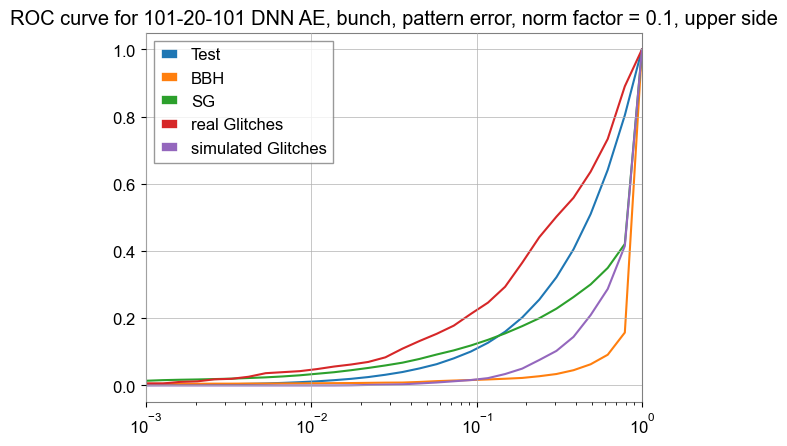

In [280]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for 101-20-101 DNN AE, bunch, pattern error, norm factor = 0.1, upper side')

Text(0.5, 1.0, 'ROC curve for 101-20-101 DNN AE, bunch, pattern error, norm factor = 0.1, lower side')

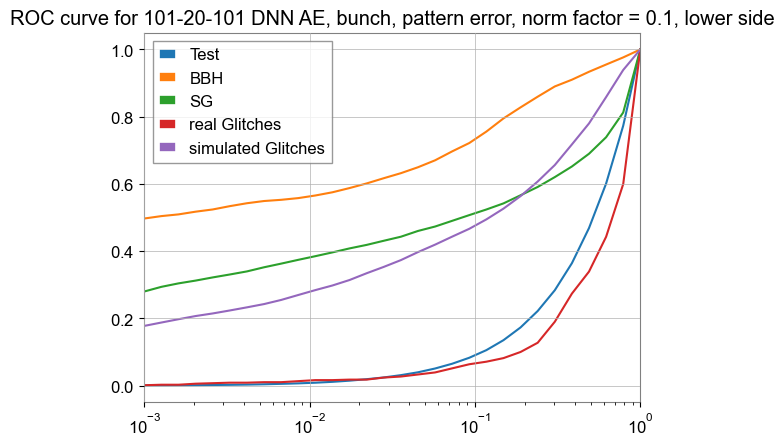

In [283]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for 101-20-101 DNN AE, bunch, pattern error, norm factor = 0.1, lower side')

Text(0.5, 1.0, 'ROC curve for 101-20-101 DNN AE, bunch, norm error, norm factor = 0.1, upper side')

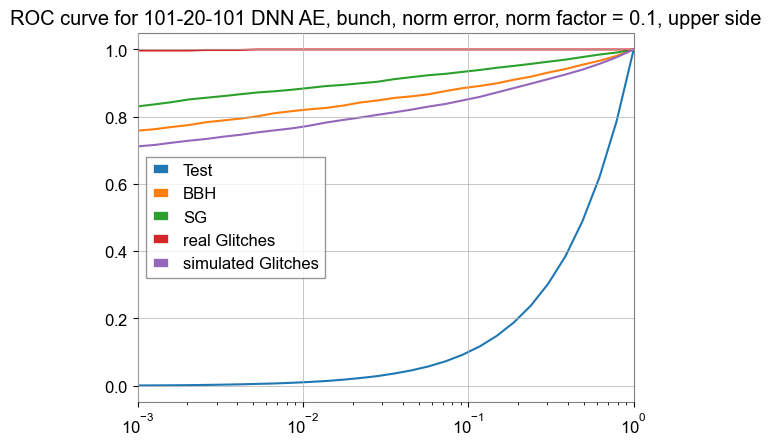

In [288]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for 101-20-101 DNN AE, bunch, norm error, norm factor = 0.1, upper side')

Text(0.5, 1.0, 'ROC curve for 101-20-101 DNN AE, bunch, norm error, norm factor = 0.1, lower side')

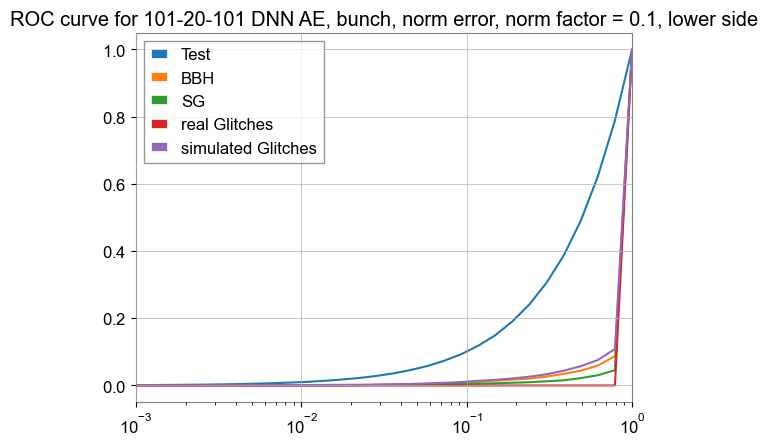

In [291]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for 101-20-101 DNN AE, bunch, norm error, norm factor = 0.1, lower side')

Fixed-Boundry consistency check
----

In [300]:
BKG = np.load('E://GWNMMAD_data/Train_Data/TRAIN_PROCESS/BKG.npy')

In [327]:
BKG = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data']

In [328]:
BKG.shape

(100000, 2, 200)

In [329]:
BKG_norm = np.linalg.norm(BKG.reshape(-1, 100), axis = 1)

In [354]:
bin_scheme_1 = np.arange(3,13,1e-2)

In [339]:
BKG_norm

array([7.24035978, 7.18792225, 6.47914914, ..., 6.31826228,
       6.45670735, 5.74522885])

Text(0.5, 1.0, 'Norm distribution for real background dataset')

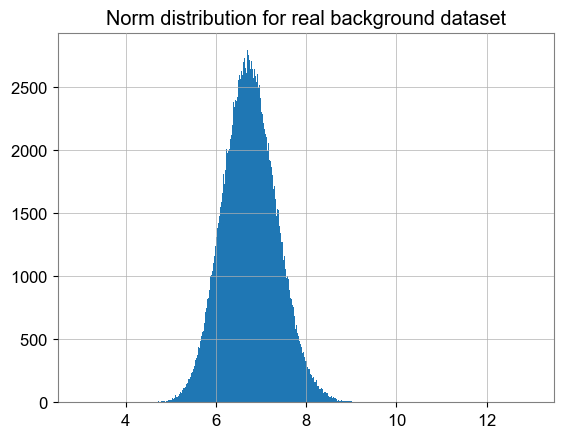

In [358]:
plt.hist(BKG_norm, bins = bin_scheme_1)
plt.title('Norm distribution for real background dataset')

In [318]:
BBH = np.load('E://GWNMMAD_data/Train_Data/TRAIN_PROCESS/BBH.npy')

In [341]:
BBH = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy')

In [342]:
BBH_norm = np.linalg.norm(BBH.reshape(-1, 100), axis = 1)

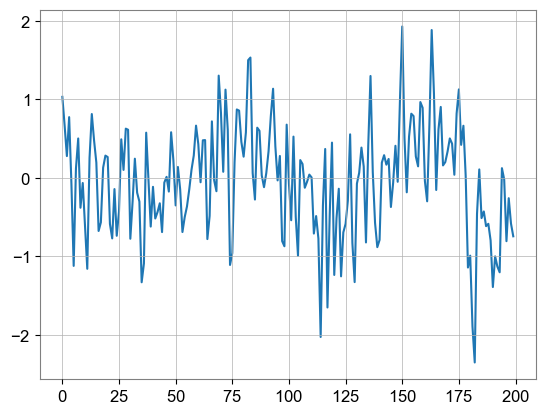

In [348]:
plt.plot(BBH[0][0])

Text(0.5, 1.0, 'Norm distribution for real BBH dataset')

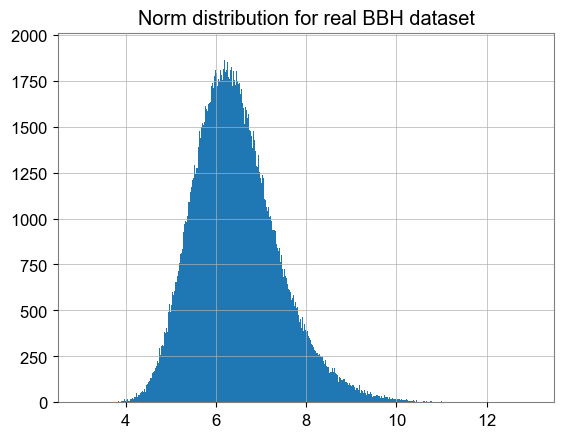

In [361]:
plt.hist(BBH_norm, bins = bin_scheme_1)
plt.title('Norm distribution for real BBH dataset')

In [349]:
SG = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy')

In [352]:
SG_norm = np.linalg.norm(SG.reshape(-1, 100), axis = 1)

Text(0.5, 1.0, 'Norm distribution for real SGLF dataset')

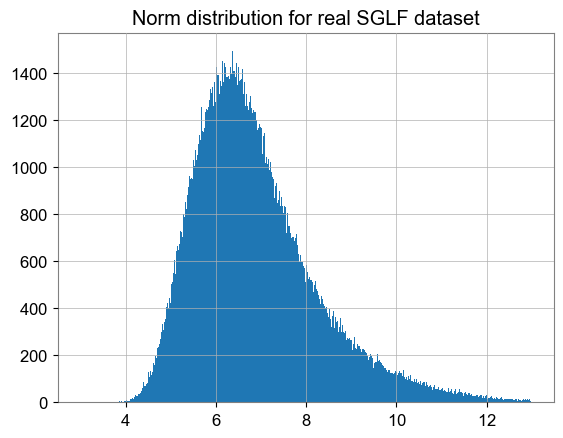

In [360]:
plt.hist(SG_norm, bins = bin_scheme_1)
plt.title('Norm distribution for real SGLF dataset')

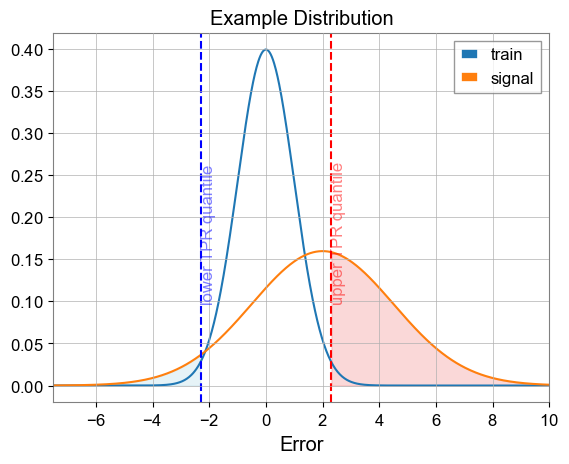

In [371]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 生成数据
np.random.seed(0)
train_mean = 0  # train正态分布的均值
train_std = 1  # train正态分布的标准差
signal_mean = 2  # signal正态分布的均值
signal_std = 2.5  # signal正态分布的标准差

x = np.linspace(-10, 10, 1000)  # x轴范围

# 计算train和signal的概率密度函数（PDF）
train_pdf = norm.pdf(x, train_mean, train_std)
signal_pdf = norm.pdf(x, signal_mean, signal_std)

# 绘制train和signal的概率密度函数曲线
plt.plot(x, train_pdf, label='train')
plt.plot(x, signal_pdf, label='signal')

# 计算train曲线上1%分位点的值
train_upper_quantile = np.percentile(train_samples, 99)
train_lower_quantile = np.percentile(train_samples, 1)

# 绘制竖虚线和标注
plt.axvline(train_upper_quantile, color='r', linestyle='--')
plt.text(train_upper_quantile, 0.1, 'upper TPR quantile', color='r', rotation=90, alpha = 0.5)

plt.axvline(train_lower_quantile, color='b', linestyle='--')
plt.text(train_lower_quantile, 0.1, 'lower TPR quantile', color='b', rotation=90, alpha = 0.5)

# 标记signal大于train曲线的面积
intersection = x[x >= train_upper_quantile]
plt.fill_between(intersection, signal_pdf[x >= train_upper_quantile], color='lightcoral',alpha = 0.3)

intersection = x[x <= train_lower_quantile]
plt.fill_between(intersection, signal_pdf[x <= train_lower_quantile], color='lightblue',alpha = 0.3)

plt.xlabel('Error')
# plt.ylabel('')
plt.title('Example Distribution')
plt.legend()
plt.xlim(-7.5, 10)

plt.show()

In [377]:
time_strain_1e4 = np.load('../Data_cached/4000Hz25msnoisesample.npy')
time_strain_1e6 = np.load('../Data_cached/4000Hz25msnoisesample1e6.npy')

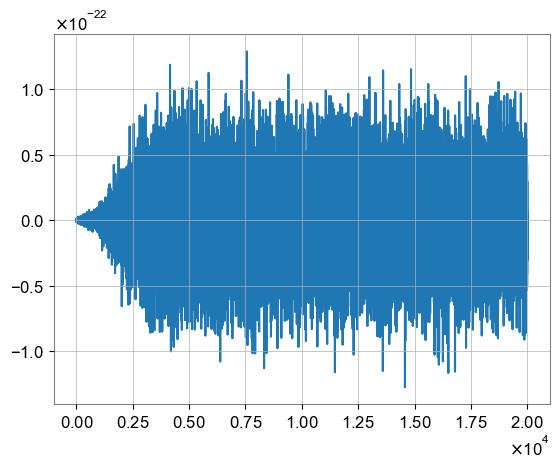

In [380]:
plt.plot(time_strain_1e4[0:200].flatten())